## transformer

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------
# 1. Positional Encoding Module
# ----------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # sine for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # cosine for odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_length, d_model)
        return x + self.pe[:, :x.size(1)]


# ----------------------------------------------
# 2. Data Preparation for Modular Arithmetic with m-ary Representation
# ----------------------------------------------
def int_to_m_ary(x, base, seq_length):
    """
    Convert an integer x into a list of digits in the specified base,
    zero-padded on the left to length seq_length.
    """
    if x == 0:
        digits = [0]
    else:
        digits = []
        while x:
            digits.append(x % base)
            x //= base
        digits = digits[::-1]
    # Pad with zeros on the left if needed.
    if len(digits) < seq_length:
        digits = [0] * (seq_length - len(digits)) + digits
    return digits

def generate_modular_integer(a, b, n, base=2, max_value=None, seq_length=16):
    """
    Generate a random integer x (in the range 1 to max_value), convert it to an m-ary representation,
    and compute the label as f(x) = a*x + b (mod n).

    Args:
        a (int): Multiplicative constant.
        b (int): Additive constant.
        n (int): Modulus.
        base (int): Base for the m-ary representation.
        max_value (int): Maximum x value. Defaults to base**seq_length - 1.
        seq_length (int): Fixed length of the m-ary string.
    
    Returns:
        digits (list[int]): List of digits (length seq_length) in the chosen base.
        label (int): Computed label (an integer from 0 to n-1).
    """
    if max_value is None:
        max_value = base ** seq_length - 1
    x = random.randint(1, max_value)
    digits = int_to_m_ary(x, base, seq_length)
    label = (a * x + b) % n
    return digits, label

class ModularArithmeticDataset(Dataset):
    def __init__(self, num_samples=10000, seq_length=16, max_value=None, a=3, b=2, n=5, base=2):
        self.samples = []
        for _ in range(num_samples):
            digits, label = generate_modular_integer(a, b, n, base, max_value, seq_length)
            digits_tensor = torch.tensor(digits, dtype=torch.long)
            label_tensor = torch.tensor(label, dtype=torch.long)
            self.samples.append((digits_tensor, label_tensor))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# ----------------------------------------------
# 3. Transformer-based Modular Arithmetic Classifier
# ----------------------------------------------
# Note: The embedding layer's num_embeddings is set to the base (vocabulary size).
class TransformerModularArithmeticClassifier(nn.Module):
    def __init__(self,
                 d_model=32,
                 nhead=4,
                 num_layers=2,
                 dim_feedforward=64,
                 dropout=0.1,
                 max_seq_length=16,
                 num_classes=5,       # n (modulus)
                 input_vocab_size=2): # base; e.g., 2 for binary, 3 for ternary, etc.
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_length)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        x = self.embedding(x)  # shape: (batch_size, seq_length, d_model)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)  # shape: (seq_length, batch_size, d_model)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)      # average pooling over the sequence
        logits = self.fc(x)    # shape: (batch_size, num_classes)
        return logits


# ----------------------------------------------
# 4. Training, Evaluation, and Inference Functions
# ----------------------------------------------
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def predict_modular(x, model, seq_length=16, device=torch.device("cpu"), base=2):
    digits = int_to_m_ary(x, base, seq_length)
    bits_tensor = torch.tensor(digits, dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(bits_tensor)
        pred = output.argmax(dim=1).item()
    return pred




## main

In [3]:
# ----------------------------------------------
# 5. Setup, Training Loop, and Demonstration
# ----------------------------------------------
if __name__ == '__main__':
    # Set the desired m-ary base here. For example, base=3 gives 3-ary (ternary) strings.
    base = 2  
    seq_length = 16         # Length of the m-ary string
    num_samples = 10000     # Number of samples in the dataset
    batch_size = 64
    num_epochs = 5
    learning_rate = 0.001

    # Modular arithmetic parameters: f(x) = a*x + b (mod n)
    a = 3
    b = 2
    n = 4  # number of classes (residues)

    # Ensure max_value fits into seq_length digits in the chosen base.
    max_value = base ** seq_length - 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create dataset and dataloader.
    dataset_mod = ModularArithmeticDataset(num_samples=num_samples, seq_length=seq_length, max_value=max_value,
                                             a=a, b=b, n=n, base=base)
    dataloader_mod = DataLoader(dataset_mod, batch_size=batch_size, shuffle=True)

    # Instantiate the model.
    # Set input_vocab_size equal to base.
    model_mod = TransformerModularArithmeticClassifier(max_seq_length=seq_length, num_classes=n,
                                                         input_vocab_size=base).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_mod.parameters(), lr=learning_rate)

    # Training loop.
    for epoch in range(num_epochs):
        train_loss = train_model(model_mod, dataloader_mod, optimizer, criterion, device)
        accuracy = evaluate_model(model_mod, dataloader_mod, device)
        print(f"Epoch {epoch + 1}/{num_epochs} -- Loss: {train_loss:.4f} -- Accuracy: {accuracy * 100:.2f}%")

    # Inference demonstration.
    input_number = 42  # You can change this to any positive integer.
    predicted_value = predict_modular(input_number, model_mod, seq_length=seq_length, device=device, base=base)
    print(f"Predicted f({input_number}) = {predicted_value} (with f(x)= {a}*x+{b} mod {n})")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5 -- Loss: 0.5201 -- Accuracy: 100.00%
Epoch 2/5 -- Loss: 0.0156 -- Accuracy: 100.00%
Epoch 3/5 -- Loss: 0.0046 -- Accuracy: 100.00%
Epoch 4/5 -- Loss: 0.0022 -- Accuracy: 100.00%
Epoch 5/5 -- Loss: 0.0014 -- Accuracy: 100.00%
Predicted f(42) = 0 (with f(x)= 3*x+2 mod 4)


In [4]:
# ----------------------------------------------
# 8. Peek at the Training Data
# ----------------------------------------------
def peek_training_data(dataset, num_samples=5):
    print(f"Displaying {num_samples} samples from the dataset:")
    for idx in range(num_samples):
        input_digits, label = dataset[idx]
        digits = input_digits.tolist()
        print(f"Sample {idx+1}: Input: {digits}  |  Label: {label.item()}")

# Peek at the first 5 samples of the modular arithmetic dataset
peek_training_data(dataset_mod, num_samples=5)


Displaying 5 samples from the dataset:
Sample 1: Input: [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  |  Label: 2
Sample 2: Input: [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]  |  Label: 2
Sample 3: Input: [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]  |  Label: 1
Sample 4: Input: [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]  |  Label: 0
Sample 5: Input: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]  |  Label: 1


## visualization

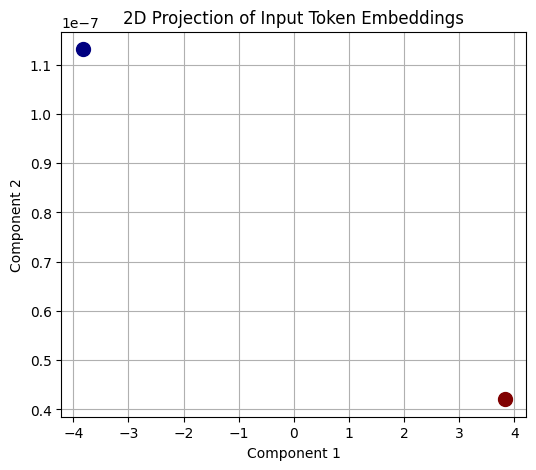

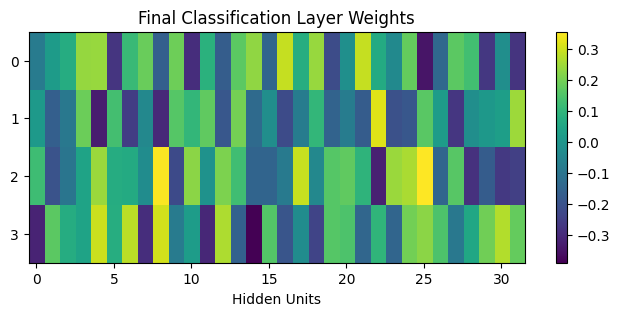

Predicted f(42) = 0 (with f(x)= 3*x+2 mod 4)


In [5]:
# ----------------------------------------------
# 7. Visualization and Prediction Section for ax+b mod n with m-ary Input
# ----------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings(model, base):
    """
    Visualize the learned embedding weights for the m-ary tokens.
    Args:
        model: The trained TransformerModularArithmeticClassifier.
        base: The numeral base (vocabulary size) used for input representation.
    """
    embeddings = model.embedding.weight.detach().cpu().numpy()  # shape: (base, d_model)
    d_model = embeddings.shape[1]
    
    # Reduce to 2D using PCA (via SVD) if necessary.
    if d_model > 2:
        embeddings_centered = embeddings - embeddings.mean(axis=0)
        U, S, Vt = np.linalg.svd(embeddings_centered, full_matrices=False)
        embeddings_2d = embeddings_centered.dot(Vt.T[:, :2])
    else:
        embeddings_2d = embeddings

    plt.figure(figsize=(6, 5))
    colors = plt.cm.jet(np.linspace(0, 1, base))
    for i in range(base):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[i], s=100)
        plt.annotate(str(i), (embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01), fontsize=12)
    plt.title("2D Projection of Input Token Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

def visualize_fc_weights(model):
    """
    Visualize the weights of the final classification layer as a heatmap.
    """
    fc_weights = model.fc.weight.detach().cpu().numpy()  # shape: (num_classes, d_model)
    plt.figure(figsize=(8, 3))
    plt.imshow(fc_weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    num_classes = fc_weights.shape[0]
    plt.yticks(range(num_classes), [str(i) for i in range(num_classes)])
    plt.xlabel("Hidden Units")
    plt.title("Final Classification Layer Weights")
    plt.show()

# Demonstration of Prediction for Modular Arithmetic
# (Assuming model_mod, a, b, n, seq_length, device, base, and predict_modular() are defined)
visualize_embeddings(model_mod, base)
visualize_fc_weights(model_mod)

input_number = 42  # Example positive integer
predicted_value = predict_modular(input_number, model_mod, seq_length=seq_length, device=device, base=base)
print(f"Predicted f({input_number}) = {predicted_value} (with f(x)= {a}*x+{b} mod {n})")
